In [2]:
papdir    = '..'
outdir    = '{0}/out'.format(papdir)
datdir    = '{0}/pf_scale200'.format(outdir)
figdir    = '{0}/figs'.format(papdir)

In [15]:
# run the simulation
cmd='python {0}/python/grn_sim_runner.py --run_pf --scale 200 --dir {1} --tau_range 0.2 4.2 0.2'.format(papdir, datdir)
!{cmd}

tau = 0.20; m1 = 1.00; noise scale = 200.00
tau = 0.40; m1 = 1.00; noise scale = 200.00
tau = 0.60; m1 = 1.00; noise scale = 200.00
tau = 0.80; m1 = 1.00; noise scale = 200.00
tau = 1.00; m1 = 1.00; noise scale = 200.00
tau = 1.20; m1 = 1.00; noise scale = 200.00
tau = 1.40; m1 = 1.00; noise scale = 200.00
tau = 1.60; m1 = 1.00; noise scale = 200.00
tau = 1.80; m1 = 1.00; noise scale = 200.00
tau = 2.00; m1 = 1.00; noise scale = 200.00
tau = 2.20; m1 = 1.00; noise scale = 200.00
tau = 2.40; m1 = 1.00; noise scale = 200.00
tau = 2.60; m1 = 1.00; noise scale = 200.00
tau = 2.80; m1 = 1.00; noise scale = 200.00
tau = 3.00; m1 = 1.00; noise scale = 200.00
tau = 3.20; m1 = 1.00; noise scale = 200.00
tau = 3.40; m1 = 1.00; noise scale = 200.00
tau = 3.60; m1 = 1.00; noise scale = 200.00
tau = 3.80; m1 = 1.00; noise scale = 200.00
tau = 4.00; m1 = 1.00; noise scale = 200.00


In [16]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import mixture

import os
import sys

sys.path.append('{0}/python'.format(papdir))
import myfun as mf
import copy

import matplotlib as mpl
#mpl.use('Agg')

from matplotlib import rc, gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches

rc('font', **{'family':'serif','serif':['Palatino']})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}') 

In [17]:
###### load stuff #######
m2 = 3
m1s       = np.load('{0}/taus.npy'.format(datdir))
gexp      = np.load('{0}/gexp.npy'.format(datdir))
alphas    = np.load('{0}/alphas.npy'.format(datdir))
drv_idxs  = np.load('{0}/driv_idxs.npy'.format(datdir))

#### process stuff ####
nm1, ncells, ngenes = gexp.shape
nresp = alphas.shape[0]


nidxs = np.where(alphas<0.5)[0]
pidxs = np.where(alphas>0.5)[0]

xidxs = np.where(drv_idxs==0)[0]
yidxs = np.where(drv_idxs==1)[0]

xnidxs = np.intersect1d(nidxs, xidxs)
xpidxs = np.intersect1d(pidxs, xidxs)
ynidxs = np.intersect1d(nidxs, yidxs)
ypidxs = np.intersect1d(pidxs, yidxs)

# clustering
ntau = len(m1s)
taus = m1s
ncomps = np.array([1,2])
nnc = ncomps.shape[0]
aics = np.zeros((ntau,nnc))
bics = np.zeros((ntau,nnc))
clust_labs = np.zeros((ntau, ncells), dtype='int')
for i in range(ntau):
    for k in range(nnc):
        gmm = mixture.GaussianMixture(n_components = ncomps[k])
        gmm.fit(gexp[i])
        if k==1:
            clust_labs[i] = gmm.predict(gexp[i])
        aics[i,k] = gmm.aic(gexp[i])
        bics[i,k] = gmm.bic(gexp[i])

bi = np.argmin(np.abs(taus-2))+1

clust0_idxs = [np.where(cl == 0)[0] for cl in clust_labs[bi:]]
clust1_idxs = [np.where(cl == 1)[0] for cl in clust_labs[bi:]]

clustA_idxs = [clust0_idxs[0]]
clustB_idxs = [clust1_idxs[0]] # arbitrary assignment 0->A, 1->B

for i in range(0,ntau-bi-1):
    muA = np.mean(gexp[bi+i,   clustA_idxs[-1]],axis=0)
    muB = np.mean(gexp[bi+i,   clustB_idxs[-1]],axis=0)
    mu0 = np.mean(gexp[bi+i+1, clust0_idxs[i+1]],axis=0)

    distA0 = np.linalg.norm(muA-mu0)
    distB0 = np.linalg.norm(muB-mu0)

    #print(distA0, distB0)

    if distA0 < distB0:
        clustA_idxs.append(clust0_idxs[i+1])
        clustB_idxs.append(clust1_idxs[i+1])
    else:
        clustA_idxs.append(clust1_idxs[i+1])
        clustB_idxs.append(clust0_idxs[i+1])

# eigenvalue 
gexp_mu  = np.mean(gexp,axis=1)
gexp_qi  = np.quantile(gexp,axis=1,q=[0.025,0.975])
gexp_err = np.std(gexp,axis=1)#/np.sqrt(ncells) #np.abs(gexp_qi-gexp_mu)

gexp_muA  = np.array([np.mean(gexp[bi+t,clustA_idxs[t],:],axis=0) for t in np.arange(gexp.shape[0]-bi)])
gexp_muB  = np.array([np.mean(gexp[bi+t,clustB_idxs[t],:],axis=0) for t in np.arange(gexp.shape[0]-bi)])

gexp_errA  = np.array([np.std(gexp[bi+t,clustA_idxs[t],:],axis=0) for t in np.arange(gexp.shape[0]-bi)])
gexp_errB  = np.array([np.std(gexp[bi+t,clustB_idxs[t],:],axis=0) for t in np.arange(gexp.shape[0]-bi)])

gexp_clustA  = list(gexp[0:bi]) + [gexp[bi+t,clustA_idxs[t]] for t in np.arange(gexp.shape[0]-bi)]
gexp_clustB  = list(gexp[0:bi]) + [gexp[bi+t,clustB_idxs[t]] for t in np.arange(gexp.shape[0]-bi)]

gexps         = [gexp, gexp_clustA, gexp_clustB]#, no_noise_gexp]
gexps_mu      = np.array(mf.apply_fun2d(lambda x: np.mean(x,axis=0), gexps))
gexps_std     = np.array(mf.apply_fun2d(lambda x: np.std(x,axis=0,ddof=1), gexps))

gexps_cent    = [[gexps[i][t]-gexps_mu[i,t] for t in range(len(gexps[i]))] for i in range(len(gexps))]
covs          = np.array(mf.apply_fun2d(lambda x: np.cov(x.T), gexps_cent))
cov_eig       = mf.apply_fun2d(np.linalg.eig, covs)

cov_evals      = np.real_if_close(np.array(mf.apply_fun2d(lambda x: x[0], cov_eig)))
cov_evecs      = np.array(mf.apply_fun2d(lambda x: x[1], cov_eig))
cov_evec0      = cov_evecs[...,0]
#cov_evec0_sign = mf.nz_sign(cov_evec0[...,0])
cov_evec0_sign = mf.nz_sign(mf.maxabs(cov_evec0,axis=2))
cov_evec0_ns   = np.real_if_close((cov_evec0.transpose((2,0,1)) * cov_evec0_sign).transpose((1,2,0)))


thresh      = 0.01
min_pk_dist = 5
max_eval_idxs = [mf.peak_idxs(cov_evals[i,:,0], thresh, min_pk_dist) for i in range(len(cov_evals))]

bif_idxs = np.array([max_eval_idxs[i][0] for i in range(len(gexps))])

# resampling gexp
nt, nc, ng = gexp.shape
nsamp = 100
npc = min(nc,ng)
pca = PCA(n_components=npc)
gene_shuf_eig1 = np.zeros([nt, nsamp,npc])
#samp_idxs = np.random.choice(nc, size=(nt, nsamp, ))
for t in range(nt):
    gexpt = gexp[t]
    for i in range(nsamp):
        gexp_shuf = np.array([gexpt[:,g][np.random.choice(nc, nc, replace=True)] for g in range(ng)]).T
        pca.fit(gexp_shuf)
        gene_shuf_eig1[t,i]=pca.explained_variance_

null_eval_mu  = np.mean(gene_shuf_eig1,axis=1)
null_eval_err = np.std(gene_shuf_eig1,axis=1)

gene_shuf_eig_norm = np.linalg.norm(gene_shuf_eig1,axis=2)
pov1_shuf          = gene_shuf_eig1[...,0]/gene_shuf_eig_norm
pov1_shuf_mu       = np.mean(pov1_shuf,axis=1)
pov1_shuf_err      = np.std( pov1_shuf,axis=1)

gexp_mut = gexps_mu.transpose((0,2,1))

l2h_idxs = np.hstack([xpidxs,ynidxs])
h2l_idxs = np.hstack([xnidxs,ypidxs])

l2h_asrt = np.arange(len(l2h_idxs)) #np.argsort(np.abs(alphas[l2h_idxs]-0.5))
h2l_asrt = np.arange(len(h2l_idxs)) #np.argsort(np.abs(alphas[h2l_idxs]-0.5))

gexp_mu_sort = np.array([np.vstack([mf.norm0to1(gexp_mut[i,[0]],1),
                          gexp_mut[i,l2h_idxs[np.flip(l2h_asrt)]+2],
                          gexp_mut[i,h2l_idxs[h2l_asrt]+2],
                          mf.norm0to1(gexp_mut[i,[1]],1)
                         ]) for i in [1,2]])

idx_grps    = [ypidxs,xpidxs,ynidxs,xnidxs]
idx_grp_srt = [np.argsort(np.abs(alphas[grp]-0.5)) for grp in idx_grps]
idxs        = np.hstack([idx_grps[i][idx_grp_srt[i]] for i in range(len(idx_grps))])+2

gexp_mu_m = gexp_mut[1:,:2] #np.array([mf.norm0to1(gexp_mut[i,0:2],1) for i in [1,2]])
gexp_mu_s = gexp_mut[1:,idxs]
gexp_mu_sort = np.array([np.vstack([mf.norm0to1(gexp_mut[i,[0]],1),
                          gexp_mut[i,idxs],
                          mf.norm0to1(gexp_mut[i,[1]],1)
                         ]) for i in [1,2]])

/var/folders/0h/m5bz9gw55x73mtvt8hyl1cd40000gs/T/ipykernel_38356/749923457.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  axA1a.set_yticklabels(np.array([r'$g_1$',r'$g_2$']))


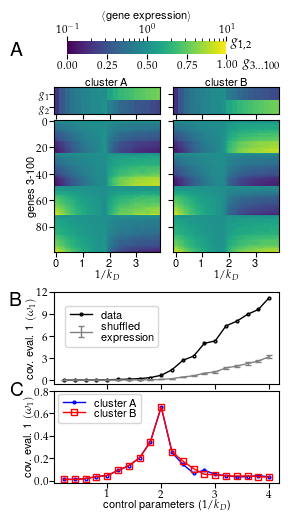

In [18]:
### the figure 
plt.style.reload_library()
plt.style.use('{0}/sty/one_col_fig.mplstyle'.format(papdir))

fac = 2
leg_ht  = int(0.5*fac)
leg_spc = int(2.5*fac)
mgexp_ht = 2*fac
spc_ht  = int(0.5*fac)
spc_ht2  = 3*fac

sgexp_ht = 10*fac
tseries_ht = 7*fac

marg_wd = 3*fac
spc_wd = int(1*fac)
gexp_wd = 8*fac
cbar_pad_left  = 1*fac
cbar_pad_right = 4*fac
cbar_wid = gexp_wd*2 + spc_wd - cbar_pad_left - cbar_pad_right


# row heights
hts = np.array([
    
    leg_ht,
    leg_ht,
    leg_spc,
    
    mgexp_ht,
    spc_ht,
    
    sgexp_ht,
    spc_ht2,
    
    tseries_ht,
    spc_ht,
    tseries_ht
])

wds = np.array([
    marg_wd,
    cbar_pad_left,
    gexp_wd - cbar_pad_left,
    spc_wd,
    gexp_wd - cbar_pad_right,
    cbar_pad_right
])

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols 

nr = np.sum(hts)
nc = np.sum(wds)

wid = 8.7/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=100) 

gs = gridspec.GridSpec(nr, nc)
gs.update(wspace=0, hspace=0) # set the spacing between axes. 


axALa = plt.subplot( gs[0    :rs[0], cs[1]:cs[4]]) 
axALb = plt.subplot( gs[rs[0]:rs[1], cs[1]:cs[4]]) 
axA1a = plt.subplot( gs[rs[2]:rs[3], cs[0]:cs[2]]) 
axA1b = plt.subplot( gs[rs[4]:rs[5], cs[0]:cs[2]]) 
axA2a = plt.subplot( gs[rs[2]:rs[3], cs[3]:cs[5]]) 
axA2b = plt.subplot( gs[rs[4]:rs[5], cs[3]:cs[5]]) 

axB   = plt.subplot( gs[rs[6]:rs[7], cs[0]:cs[5]]) # time series
axC   = plt.subplot( gs[rs[8]:rs[9], cs[0]:cs[5]]) # time series

axAC  = plt.subplot( gs[0    :1      , 0:cs[0]])  
axBC  = plt.subplot( gs[rs[6]:rs[6]+1, 0:cs[0]])  
axCC  = plt.subplot( gs[rs[8]:rs[8]+1, 0:cs[0]])  


cap_axs = [axAC,axBC,axCC]
caps = ['A','B','C']
ys = [1,1,2.5]
for i in range(len(cap_axs)):
    cap_axs[i].text(s=caps[i],x=-0.1,y=ys[i],fontsize=14, fontweight='bold', 
                    verticalalignment='top',horizontalalignment='left')
    cap_axs[i].axis('off')


#####################################
## A: gene expression              ##
#####################################
vmin = 0 
vmax = 1
vminm = -1
vmaxm = 1
bifvarlab = r'$1/k_D$'

im0 = axA1a.imshow(gexp_mu_m[0],aspect='auto', norm=mpl.colors.LogNorm(vmin=10**vminm,vmax=10**vmaxm))
im1 = axA1b.imshow(gexp_mu_s[0],aspect='auto', vmin = vmin, vmax = vmax)
im0 = axA2a.imshow(gexp_mu_m[1],aspect='auto', norm=mpl.colors.LogNorm(vmin=10**vminm,vmax=10**vmaxm))# vmin = vminm, vmax = vmaxm)
im1 = axA2b.imshow(gexp_mu_s[1],aspect='auto', vmin = vmin, vmax = vmax)

axA1a.set_yticklabels(np.array([r'$g_1$',r'$g_2$']))
axA1a.set_yticks([0,1])
axA2a.set_yticklabels([])
axA2b.set_yticklabels([])

axA1a.set_title('cluster A')
axA2a.set_title('cluster B')

xtix = np.arange(0,len(m1s),5)
axA1a.set_xticklabels([])
axA2a.set_xticklabels([])
axA1a.set_xticks(xtix)
axA1b.set_xticks(xtix)
axA2a.set_xticks(xtix)
axA2b.set_xticks(xtix)

xlabs = ['{0:.0f}'.format(m1s[x]) for x in xtix]
axA1b.set_xticklabels(xlabs)
axA2b.set_xticklabels(xlabs)


axA1b.set_xlabel(bifvarlab)
axA2b.set_xlabel(bifvarlab)

axA1b.set_ylabel('genes 3-100')

cbar1 = fig.colorbar(im0, cax=axALa, orientation='horizontal', aspect=1)
cbar1.set_label(r'$\langle$gene expression$\rangle$',rotation=0,labelpad=5)


axALa.xaxis.set_label_position('top')
axALa.xaxis.set_ticks_position('top')

axALa.spines['bottom'].set_visible(False)
axALb.spines['top'].set_visible(False)


locmaj = mpl.ticker.LogLocator(base=10,numticks=100) 
axALa.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0,1,0.1),numticks=100)
axALa.xaxis.set_minor_locator(locmin)



cbar2 = fig.colorbar(im1, cax=axALb, orientation='horizontal', aspect=1)

axALa.text(s=r'$g_{1,2}$',x=1.02,y=-0.25,verticalalignment='bottom',horizontalalignment='left',
          transform=axALa.transAxes)
axALb.text(s=r'$g_{3...100}$',x=1.1,y=-0.25,verticalalignment='top',horizontalalignment='left',
          transform=axALb.transAxes)
cbar1.outline.set_visible(False)
cbar2.outline.set_visible(False)



#####################################
## B: covariance eigenvalue         ##
#####################################
axB.plot(m1s, np.real(cov_evals[0,:,0]),'o-', color='k',fillstyle='none', label='data')
axB.errorbar(m1s, null_eval_mu[:,0], yerr = null_eval_err[:,0], color='gray', 
             capsize=2, label='shuffled\nexpression')
axB.set_xticklabels([])
axB.legend(labelspacing=0,loc=(0.05,0.4))
axB.set_yticks(np.arange(0,14,3))
axB.set_ylabel(r'cov. eval. 1 $(\omega_1)$')

#####################################
## C: covariance eigenvalue         ##
#####################################
axC.plot(m1s, np.real(cov_evals[1,:,0]),'o-', color='b',fillstyle='none', label='cluster A')
axC.plot(m1s, np.real(cov_evals[2,:,0]),'s-', color='r',fillstyle='none', label='cluster B',markersize=5)
axC.set_xlabel('control parameters ('+bifvarlab+')')
axC.legend(labelspacing=0,loc=(0.02,0.65))
axC.set_yticks(np.arange(0,0.9,0.2))
axC.set_ylabel(r'cov. eval. 1 $(\omega_1)$')

plt.savefig('{0}/figS5_pitchfork.pdf'.format(figdir), bbox_inches='tight')

In [19]:
xtix, m1s

(array([ 0,  5, 10, 15]),
 array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
        2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]))